In [6]:
import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from pyscf import gto, scf
import matplotlib.pyplot as plt
import pandas as pd

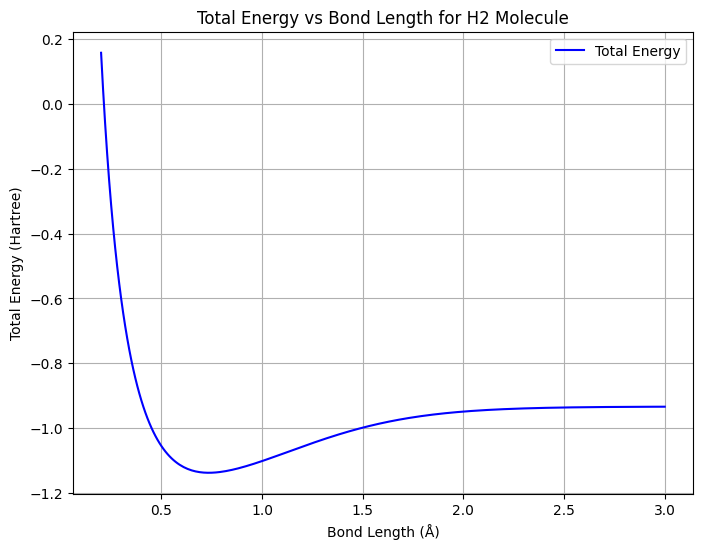

In [7]:
def total_energy(bond_length):
    """
    Calculate the total energy and nuclear repulsion energy of H2 for a given bond length using PySCF.
    
    Parameters:
    bond_length (float): The bond length in Angstroms.
    
    Returns:
    tuple: The calculated total energy and nuclear repulsion energy in Hartree.
    """
    # Define the H2 molecule at the specified bond length
    
    driver = PySCFDriver(
    atom=f"H 0 0 {-bond_length/2}; H 0 0 {bond_length/2}",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
    )
    
    molecule = driver.run()   
    # Step 3: Apply the FreezeCoreTransformer to freeze core electrons
    transformer = FreezeCoreTransformer()
    transformed_molecule = transformer.transform(molecule)

    nuclear_repulsion_energy = transformed_molecule.nuclear_repulsion_energy
    core_electron_energy = transformed_molecule.hamiltonian.constants['FreezeCoreTransformer']
    
    # Step 5: Map the Hamiltonian to a Fermionic Operator
    fermionic_op = transformed_molecule.hamiltonian.second_q_op()
    
    # Step 6: Convert the Fermionic Operator to a Qubit Operator using Jordan-Wigner Mapper
    mapper = JordanWignerMapper()
    qubit_op = mapper.map(fermionic_op)
    
    # Step 7: Convert the Qubit Operator to a matrix
    hamiltonian_matrix = qubit_op.to_matrix()
    electronic_energy = np.min(np.linalg.eigvals(hamiltonian_matrix))
    
    return nuclear_repulsion_energy, electronic_energy, core_electron_energy

def generate_energy_curve(start, stop, num_points):
    """
    Generate the total energy curve for H2 molecule over a range of bond lengths.
    
    Parameters:
    start (float): The starting bond length in Angstroms.
    stop (float): The stopping bond length in Angstroms.
    num_points (int): Number of points between start and stop bond lengths.
    
    Returns:
    tuple: Arrays containing bond lengths and corresponding total energies.
    """
    bond_lengths = np.arange(start, stop + spacing, spacing)
 
    total_energies = []
    nuclear_repulsion_energy_list = []
    electronic_energy_list = []
    frozen_electron_energy_list = []
    for bond_length in bond_lengths:
        nuclear, electronic, frozen_electron_energy = total_energy(bond_length)
        total_energies.append(nuclear + electronic + frozen_electron_energy)
        nuclear_repulsion_energy_list.append(nuclear)
        electronic_energy_list.append(electronic)
        frozen_electron_energy_list.append(frozen_electron_energy)
        
    return bond_lengths, np.real(total_energies), np.real(nuclear_repulsion_energy_list), np.real(electronic_energy_list), np.real(frozen_electron_energy_list)  

# Define bond length range and number of points
start = 0.2  # Starting bond length in Angstroms
stop = 3.0   # Ending bond length in Angstroms
spacing = 0.01  # Spacing between points in Angstroms
num_points = int((stop - start) / spacing) + 1

# Generate the energy curve
bond_lengths, total_energies, nuclear_repulsion_energy_list, electronic_energy_list, frozen_electron_energy_list = generate_energy_curve(start, stop, num_points)

plt.figure(figsize=(8, 6))
plt.plot(bond_lengths, total_energies, label='Total Energy', color='blue')
plt.title("Total Energy vs Bond Length for H2 Molecule")
plt.xlabel("Bond Length (Å)")
plt.ylabel("Total Energy (Hartree)")
# plt.axhline(0, color='red', linestyle='--', label='Zero Energy Reference')
plt.grid(True)
plt.legend()

plt.show()


In [8]:
# Combine the arrays into a DataFrame
df = pd.DataFrame({
    "BL": bond_lengths,
    "NRE": np.real(nuclear_repulsion_energy_list),
    "EE": np.real(electronic_energy_list) + np.real(frozen_electron_energy_list),
})

# Save the DataFrame to a CSV file
df.to_csv('exact_curve.csv', index=False)
